In [63]:
# Most of the code has been completed for you. 
# To complete Exercise 8.11: 
  # Part a: Run the function RunStochasticRepressilator 
              #RunStochasticRepressilator(T=24000, dt=1., plots=True, plotPromoter=True)
  # Part b: Write code for the class DeterministicRepressilator. Then run
  #           the function CompareDetSto
  # Part c: Incorporate RNAFactor in CompareDetStoc
  # Part d: Incorporate TelegraphFactor in CompareDetStoc


import scipy
import scipy.integrate
import random

#import RepressilatorAnimation
#RepressilatorAnimation.ClearScene()
#animator = RepressilatorAnimation.RepressilatorAnimator()

class Chemical:

    """Chemical is a class describing chemicals and/or chemical complexes.
    Chemical.amount: the amount of the Chemical in the cell.
    Chemical.reactions: a list of reactions whose rates are changed if
    Chemical.amount is altered."""

    def __init__(self, amount):
        # Chemical.amount represents the amount of this Chemical in the cell
        self.amount = amount
        # Chemical.reactions is a list of reactions whose rates are changed if
        # Chemical.amount is altered.
        self.reactions = []


class DegradationReaction:

    """DegradationReaction describes the removal of one molecule of
    the specified substrate, with specified rate_constant.
    Overall rate for this reaction to occur is
    substrate.amount * rate_constant."""

    def __init__(self, substrate, rate_constant):
        self.stoichiometry = {substrate: -1}
        self.substrate = substrate
        self.rate_constant = rate_constant
        substrate.reactions.append(self)

    def GetRate(self):
        return self.substrate.amount * self.rate_constant


class CatalyzedSynthesisReaction:

    """CatalyzedSynthesisReaction describes the synthesis of product in'
    the presence of a catalyst:  catalyst -> catalyst + product,
    with specified rate_constant.
    Overall rate for this reaction to occur is
    catalyst.amount * rate_constant."""

    def __init__(self, catalyst, product, rate_constant):
        self.stoichiometry = {product: 1}
        self.catalyst = catalyst
        self.rate_constant = rate_constant
        product.reactions.append(self)

    def GetRate(self):
        return self.catalyst.amount * self.rate_constant


class HeterodimerBindingReaction:

    """HeterodimerBindingReaction describes the binding of two distinct
    types of chemicals, A and B, to form a product dimer: A + B -> dimer,
    with specified rate_constant.
    Overall rate for this reaction to occur is
    A.amount * B.amount * rate_constant."""

    def __init__(self, A, B, dimer, rate_constant):
        self.stoichiometry = {A: -1, B: -1, dimer: 1}
        self.A = A
        self.B = B
        self.rate_constant = rate_constant
        A.reactions.append(self)
        B.reactions.append(self)
        dimer.reactions.append(self)

    def GetRate(self):
        return self.A.amount * self.B.amount * self.rate_constant


class HeterodimerUnbindingReaction:

    """HeterodimerBindingReaction describes the unbinding of a
    heterodimer into two distinct types of chemicals, A and B:
    dimer -> A + B, with specified rate_constant.
    Overall rate for this reaction to occur is
    dimer.amount * rate_constant."""

    def __init__(self, dimer, A, B, rate_constant):
        self.stoichiometry = {A: 1, B: 1, dimer: -1}
        self.dimer = dimer
        self.rate_constant = rate_constant
        A.reactions.append(self)
        B.reactions.append(self)
        dimer.reactions.append(self)

    def GetRate(self):
        return self.dimer.amount * self.rate_constant

# ---------------------------------------------------------------------


class CNV_model:

    """
    CNV Model is a base class for the four-gene system.

    The set of Chemical states (all 5 mRNAs, all 4 proteins, and all 10
    promoter states) have a defined ordering, as stored in the
    dictionary chemIndex, which maps Chemicals to integer indices in
    the ordering.  This ordering is necessary to communicate with utilities
    (such as scipy.integrate.odeint) that require chemical amounts to
    be stored as a 1D array.  The GetStateVector method returns the
    Chemical amounts as a scipy array in the appropriate order, and
    the SetStateVector method sets the Chemical amounts based on a
    supplied array.
    """

    def __init__(self,
                 dox,
                 mRNA_degradation_rate=scipy.log(2.) / 120.,
                 protein_degradation_rate=scipy.log(2.) / 600.,
                 translation_rate=0.167,
                 unocc_transcription_rate=5.0e-08,
                 activated_transcription_rate=0.25,
                 double_activated_transcription_rate=0.5,
                 inhibited_transcription_rate=5.0e-08,
                 P_binding=1.0,
                 P1_unbinding=224.0,
                 P2_unbinding=9.0,
                 dox_binding_rate=0.05,
                 dox_unbinding_rate=0.1):
        self.t = 0.
        self.chemIndex = {}
        self.reactions = []
        
        # Rates
        self.mRNA_degradation_rate = mRNA_degradation_rate
        self.protein_degradation_rate = protein_degradation_rate
        self.translation_rate = translation_rate
        self.unocc_transcription_rate = unocc_transcription_rate
        self.act_transcription_rate = activated_transcription_rate
        self.double_act_transcription_rate = double_activated_transcription_rate
        self.inh_transcription_rate = inhibited_transcription_rate
        self.dox_binding_rate = dox_binding_rate
        self.dox_unbinding_rate = dox_unbinding_rate
        self.P_binding = P_binding
        self.P1_unbinding = P1_unbinding
        self.P2_unbinding = P2_unbinding
        
        # small molecule
        self.dox_concentration = round(dox * 10 * 6.02 * 5.23 / 444.4) # Cell volume (5.23 * 10^-16) is in meters cubed
        self.dox = Chemical(self.dox_concentration)
        self.AddChemical(self.dox)
        # Proteins
        self.NANOG = Chemical(12000.0)
        self.GATA6 = Chemical(0.0)
        self.FOXA2 = Chemical(0.0)
        self.FOXF1 = Chemical(0.0)
        self.TETO = Chemical(500.0)
        self.TETO_dox = Chemical(0.0)
        
        # mRNAs
        self.nanog = Chemical(80.0)
        self.gata6 = Chemical(0.0)
        self.foxa2 = Chemical(0.0)
        self.foxf1 = Chemical(0.0)
        
        # Promoter States
        # Unbound (Default) each promoter has 2 copies. except exogenous gata6 (The synthetic Circuit)
        self.Pnanog = Chemical(2.0)
        self.Pgata6 = Chemical(2.0)
        self.Pgata6_exo = Chemical(2.0) ## THIS IS WHERE CNV WOULD BE IMPORTANT
        self.Pfoxa2 = Chemical(2.0)
        self.Pfoxf1 = Chemical(2.0)
        
        # Single bound activated States
        self.Pnanog_NANOG = Chemical(0.0)
        self.Pgata6_GATA6 = Chemical(0.0)
        self.Pgata6_exo_TETO_dox = Chemical(0.0)
        self.Pfoxa2_GATA6 = Chemical(0.0)
        self.Pfoxf1_GATA6 = Chemical(0.0)
        self.Pfoxa2_FOXA2 = Chemical(0.0)
        self.Pfoxf1_FOXF1 = Chemical(0.0)
        
        # Single bound inhibited states
        self.Pnanog_GATA6 = Chemical(0.0)
        self.Pgata6_NANOG = Chemical(0.0)
        self.Pfoxa2_FOXF1 = Chemical(0.0)
        self.Pfoxf1_FOXA2 = Chemical(0.0)
        
        # Double bound activated states
        self.Pfoxa2_GATA6_FOXA2 = Chemical(0.0)
        self.Pfoxf1_GATA6_FOXF1 = Chemical(0.0)
        
        # Double bound inhibited states
        self.Pfoxa2_GATA6_FOXF1 = Chemical(0.0)
        self.Pfoxf1_GATA6_FOXA2 = Chemical(0.0)
        
        self.mRNAs = [self.nanog, self.gata6, self.foxa2, self.foxf1]
        self.proteins = [self.NANOG, self.GATA6, self.FOXA2, self.FOXF1, self.TETO_dox, self.TETO]
        self.P0 = [self.Pnanog, self.Pgata6, self.Pfoxa2, self.Pfoxf1, self.Pgata6_exo]
        self.P0_unocc_transcription_ref = [0, 1, 2, 3, 1]
        self.P0_inhib_binding_ref = [1, 0, 3, 2]
        self.P1_active = [self.Pnanog_NANOG, self.Pgata6_GATA6, self.Pgata6_exo_TETO_dox, self.Pfoxa2_GATA6, self.Pfoxf1_GATA6, self.Pfoxa2_FOXA2, self.Pfoxf1_FOXF1]
        self.P1_active_mRNA_ref = [0, 1, 1, 2, 3, 2, 3]
        self.P1_inhib = [self.Pnanog_GATA6, self.Pgata6_NANOG, self.Pfoxa2_FOXF1, self.Pfoxf1_FOXA2]
        self.P2_active = [self.Pfoxa2_GATA6_FOXA2, self.Pfoxf1_GATA6_FOXF1]
        self.P2_inhib = []
        # self.P2_inhib = [self.Pfoxa2_GATA6_FOXF1, self.Pfoxf1_GATA6_FOXA2]
        for chem in self.mRNAs:
            self.AddChemical(chem)
        for chem in self.proteins:
            self.AddChemical(chem)
        for chem in self.P0:
            self.AddChemical(chem)
        for chem in self.P1_active:
            self.AddChemical(chem)
        for chem in self.P1_inhib:
            self.AddChemical(chem)
        for chem in self.P2_active:
            self.AddChemical(chem)
        for chem in self.P2_inhib:
            self.AddChemical(chem)
            
        self.AddReaction(
            HeterodimerBindingReaction(self.TETO,
                                      self.dox,
                                      self.TETO_dox,
                                      self.dox_binding_rate))
        
        self.AddReaction(
            HeterodimerUnbindingReaction(self.TETO_dox,
                                      self.TETO,
                                      self.dox,
                                      self.dox_unbinding_rate))
            
        # Adding mRNA reactions
        for i in range(len(self.mRNAs)):
            self.AddReaction(
                DegradationReaction(self.mRNAs[i], self.mRNA_degradation_rate))
            self.AddReaction(
                CatalyzedSynthesisReaction(self.mRNAs[i], self.proteins[i],
                                          self.translation_rate))
        for i in range(len(self.proteins)-2):
            self.AddReaction(
                DegradationReaction(self.proteins[i], self.protein_degradation_rate))
        for i in range(len(self.P0)):
            self.AddReaction(
                CatalyzedSynthesisReaction(self.P0[i],
                                           self.mRNAs[self.P0_unocc_transcription_ref[i]],
                                           self.unocc_transcription_rate))
        for i in range(len(self.P1_active)):
            self.AddReaction(
                CatalyzedSynthesisReaction(self.P1_active[i],
                                           self.mRNAs[self.P1_active_mRNA_ref[i]],
                                           self.act_transcription_rate))
        for i in range(len(self.P1_inhib)):
            self.AddReaction(
                CatalyzedSynthesisReaction(self.P1_inhib[i],
                                           self.mRNAs[i],
                                           self.inh_transcription_rate))
        for i in range(len(self.P2_active)):
            self.AddReaction(
                CatalyzedSynthesisReaction(self.P2_active[i],
                                           self.mRNAs[i+2],
                                           self.double_act_transcription_rate))
        for i in range(len(self.P2_inhib)):
            self.AddReaction(
                CatalyzedSynthesisReaction(self.P2_inhib[i],
                                           self.mRNAs[i+2],
                                           self.inh_transcription_rate))
        
        # Activating P0 reactions
        for i in range(len(self.P0)):
            self.AddReaction(
                HeterodimerBindingReaction(self.P0[i],
                                           self.proteins[i],
                                           self.P1_active[i],
                                           P_binding))
            self.AddReaction(
                HeterodimerUnbindingReaction(self.P1_active[i],
                                             self.P0[i],
                                             self.proteins[i],
                                             P1_unbinding))
        
        # Inhibiting P0 reactions
        for i in range(len(self.P0)-1):
            self.AddReaction(
                HeterodimerBindingReaction(self.P0[i],
                                           self.proteins[self.P0_inhib_binding_ref[i]],
                                           self.P1_inhib[i],
                                           P_binding))
            self.AddReaction(
                HeterodimerUnbindingReaction(self.P1_inhib[i],
                                             self.P0[i],
                                             self.proteins[self.P0_inhib_binding_ref[i]],
                                             P1_unbinding))
                       
        # Activating P1 -> P2 reactions
        for i in range(len(self.P2_active)):
            self.AddReaction(
                HeterodimerBindingReaction(self.P1_active[i+3],
                                           self.proteins[i+2],
                                           self.P2_active[i],
                                           P_binding))
            self.AddReaction(
                HeterodimerUnbindingReaction(self.P2_active[i],
                                             self.P1_active[i+3],
                                             self.proteins[i+2],
                                             P2_unbinding))

        self.rates = scipy.zeros(len(self.reactions), float)
        for rIndex, r in enumerate(self.reactions):
            self.rates[rIndex] = r.GetRate()

    def AddChemical(self, chemical):
        self.chemIndex[chemical] = len(self.chemIndex)

    def GetChemicalIndex(self, chemical):
        return self.chemIndex[chemical]

    def AddReaction(self, reaction):
        self.reactions.append(reaction)

    def GetStateVector(self):
        c = scipy.zeros(len(self.chemIndex), float)
        for chem, index in list(self.chemIndex.items()):
            c[index] = chem.amount
        return c

    def SetFromStateVector(self, c):
        for chem, index in list(self.chemIndex.items()):
            chem.amount = c[index]


class StochasticCNV (CNV_model):

    """
    StochasticRepressilator is a stochastic implementation of
    the three-gene repressilator system, with time evolution implemented
    using Gillespie's Direct Method, as described in detail in Step.
    """

    def ComputeReactionRates(self):
        """ComputeReactionRates computes the current rate for every
        reaction defined in the network, and stores the rates in self.rates."""
        for index, r in enumerate(self.reactions):
            self.rates[index] = r.GetRate()

    def Step(self, dtmax):
        """Step(self, dtmax) implements Gillespie's Direct Simulation Method,
        executing at most one reaction and returning the time increment
        required for that reaction to take place.  If no reaction is executed,
        the specified maximal time increment dtmax is returned.

        (1) all reaction rates are computed
        (2) a total rate for all reactions is found
        (3) a random time is selected, to be drawn from an exponential
            distribution with mean value given by the inverse of the total
            rate, e.g., ran_dtime = -scipy.log(1.-random.random())/total_rate
        (4) if the random time is greater than the time interval under
            consideration (dtmax), then no reaction is executed and dtmax
            is returned
        (5) otherwise, a reaction is chosen at random with relative
            probabilities given by the relative reaction rates;
            this is done by
            (5a) uniformly drawing a random rate from the interval from
                 [0., total rate)
            (5b) identifying which reaction rate interval corresponds to
                 the randomly drawn rate, e.g.,

                 |<-------------------total rate---------------------->|
                 |<----r0----->|<-r1->|<--r2-->|<-----r3----->|<--r4-->|
                 |                                 X                   |

                 Randomly drawn rate X lands in interval r3
        (6) the chosen reaction is executed
        (7) the time at which the reaction is executed is returned
        """
        self.ComputeReactionRates()
        total_rate = sum(self.rates)
        # get exponentially distributed time
        ran_time = -scipy.log(1. - random.random()) / total_rate
        if ran_time > dtmax:
            return dtmax
        # get uniformly drawn rate in interval defined by total_rate
        ran_rate = total_rate * random.random()
        # find interval corresponding to random rate
        reac_index = len(self.rates) - sum(scipy.cumsum(self.rates) > ran_rate)
        reaction = self.reactions[reac_index]
        # execute specified reaction
        for chem, dchem in list(reaction.stoichiometry.items()):
            chem.amount += dchem
        # return time at which reaction takes place
        return ran_time

    def Run(self, T, delta_t=0.0):
        """Run(self, T, delta_t) runs the StochasticRepressilator for
        a specified time interval T, returning the trajectory at
        specified time intervals delta_t (or, if delta_t == 0.0, after
        every reaction)
        """
        tfinal = self.t + T
        if delta_t == 0.:
            ts = [self.t]
            trajectory = [self.GetStateVector()]
            while self.t < tfinal:
                dt = self.Step(tfinal - self.t)
                self.t += dt
                ts.append(self.t)
                trajectory.append(self.GetStateVector())
            return scipy.array(ts), scipy.array(trajectory)
        else:
            eps = 1.0e-06
            ts = scipy.arange(0., T + eps, delta_t)
            trajectory = scipy.zeros((len(ts), len(self.chemIndex)),
                                     float)
            trajectory[0] = self.GetStateVector()
            tindex = 0
            while self.t < tfinal:
                dt = self.Step(ts[tindex + 1] - self.t)
                self.t += dt
                if self.t >= ts[tindex + 1]:
                    tindex += 1
                    for chem, cindex in list(self.chemIndex.items()):
                        trajectory[tindex][cindex] = chem.amount
            return ts, trajectory


class DeterministicCNV (CNV_model):

    """
    DeterministicRepressilator is a deterministic implementation of
    the three-gene repressilator system, with time evolution implemented
    by summing up all reactions as appropriate to form a differential
    equation describing the time rate of change of all chemical
    constituents in the model.
    """

    def dcdt(self, c, t):
        """dcdt(self, c, t) returns the instantaneous time rate of
        change of the DeterministicRepressilator system, given chemical
        concentration state vector c and current time t, for use in
        integration by scipy.integrate.odeint.

        dcdt loops through all reactions defined in the Repressilator
        system, computes the rates of those reactions, and increments
        those elements in a dc_dt array that are affected by the
        reaction under consideration.

        the fully assembled dc_dt array is returned by this method.
        """
        self.SetFromStateVector(c)
        dc_dt = scipy.zeros(len(self.chemIndex), dtype=float)
        for index, r in enumerate(self.reactions):
          rate = r.GetRate()
          for chem, dchem in list(r.stoichiometry.items()):
            dc_dt[self.chemIndex[chem]] += (dchem * rate)
        return dc_dt

    def Run(self, tmax, dt):
        """Run(self, tmax, dt) integrates the DeterministicRepressilator
        for a time tmax, returning the trajectory at time steps as
        specified by dt, by calling scipy.integrate.odeint with the
        self.dcdt method describing the time derivative of the system

        Run should return the time array on which the trajectory is computed,
        along with the trajectory corresponding to those time points.
        """
        eps = 1.0e-06
        ts = scipy.arange(0, tmax + eps, dt)
        c = self.GetStateVector()
        traj = scipy.integrate.odeint(self.dcdt, c, ts)
        self.SetFromStateVector(traj[-1])
        
        return ts, traj


def RunStochasticCNV(dox, T=100., dt=1., plots=False, plotPromoter=False):
    """RunStochasticRepressilator(tmax, dt, plots=False, plotPromoter=False)
    creates and runs a StochasticRepressilator for the specified time
    interval T, returning the trajectory in time increments dt,
    optionally using pylab to make plots of mRNA,
    protein, and promoter amounts along the trajectory.
    """
    sr = StochasticCNV(dox)
    sts, straj = sr.Run(T, dt)
    curvetypes = ['r-', 'g-', 'b-', 'k-', 'm-', 'c-']
    if plots:
        import pylab
        pylab.figure(1)
        pylab.title("RNAs")
        for i in range(len(sr.mRNAs)):
            pylab.plot(sts, straj[:, sr.chemIndex[sr.mRNAs[i]]], curvetypes[i])
            pylab.legend(['nanog', 'gata6', 'foxa2', 'foxf1'])
        pylab.figure(2)
        pylab.title("Proteins")
        for i in range(len(sr.proteins)):
            pylab.plot(
                sts,
                straj[
                    :,
                    sr.chemIndex[
                        sr.proteins[i]]],
                curvetypes[i])
            pylab.legend(['NANOG', 'GATA6', 'FOXA2', 'FOXF1', 'TETO-dox', 'TETO'])
        if plotPromoter:
            pylab.figure(3)
            pylab.title("Promoter States")
            for i in range(3):
                promoter_state = (0.99 + 0.01 * i) *\
                                 (straj[:, sr.chemIndex[sr.P1[i]]]
                                  + 2. * straj[:, sr.chemIndex[sr.P2[i]]])
                pylab.plot(sts, promoter_state, curvetypes[i])
        pylab.show()
    return sr, sts, straj


def RunDeterministicCNV(dox, T=100., dt=1., plots=False,
                                  plotPromoter=False):
    """RunDeterministicRepressilator(tmax, dt, plots=False, plotPromoter=False)
    creates and runs a DeterministicRepressilator for the specified time
    interval T, returning the trajectory in time increments dt,
    optionally using pylab to make plots of mRNA, protein,
    and promoter amounts along the trajectory.
    """
    dr = DeterministicCNV(dox)
    dts, dtraj = dr.Run(T, dt)
    curvetypes = ['r-', 'g-', 'b-', 'k-', 'm-', 'c-']
    if plots:
        import pylab
        pylab.figure(1)
        for i in range(len(dr.mRNAs)):
            pylab.plot(dts, dtraj[:, dr.chemIndex[dr.mRNAs[i]]], curvetypes[i])
            pylab.legend(['nanog', 'gata6', 'foxa2', 'foxf1'])
        pylab.figure(2)
        for i in range(len(dr.proteins)):
            pylab.plot(
                dts,
                dtraj[
                    :,
                    dr.chemIndex[
                        dr.proteins[i]]],
                curvetypes[i])
            pylab.legend(['NANOG', 'GATA6', 'FOXA2', 'FOXF1', 'TETO-dox', 'TETO'])
        if plotPromoter:
            pylab.figure(3)
            for i in range(3):
                promoter_state = (0.99 + 0.01 * i) *\
                                 (dtraj[:, dr.chemIndex[dr.P1[i]]]
                                  + 2. * dtraj[:, dr.chemIndex[dr.P2[i]]])
                pylab.plot(dts, promoter_state, curvetypes[i])
        pylab.show()
    return dr, dts, dtraj


def CompareDetSto(dox, tmax=100., dt=1., RNAFactor=1.0, TelegraphFactor=1.0,
                  plots=True, plotPromoter=False):
    """
    CompareDetSto compares the Deterministic and Stochastic variants of
    the Repressilator by running each, and plotting the trajectories
    alongside each other.  It is useful to return both of the Repressilator
    instances as well as both of the trajectories created.

    CompareDetSto(tmax, dt) runs each Repressilator for tmax seconds,
    returning the trajectory for each in increments of dt.

    The argument plots is a boolean variable affecting whether or not
    the RNA and protein concentrations for each Repressilator are plotted.

    The argument plotPromoter is a boolean variable affecting whether or not
    the various promoter states are plotted.  Because the promoter states
    switch discretely (in the StochasticRepressilator) between 0, 1, and 2,
    it is useful to separate them from each other so what the state of
    each can be ascertained.  

    To incorporate RNAFactor and TelegraphFactor:
      - initial RNA concentrations and the transcription rate are multiplied by
      RNAFactor, and the translation rate is divided by RNAFactor, thereby
      increasing RNA concentrations without otherwise affecting the continuum
      equations
      - promoter binding and unbinding rates are multiplied by TelegraphFactor
    """

    r0 = CNV_model(dox)
    sr = StochasticCNV(dox)
    sts, straj = sr.Run(tmax, dt)
    dr = DeterministicCNV(dox)
    dts, dtraj = dr.Run(tmax, dt)
    if plots:
        import pylab
        pylab.figure(1)
        pylab.title("RNAs")
        pylab.plot(sts, straj[:, 0], 'r-')
        pylab.plot(sts, straj[:, 1], 'b-')
        pylab.plot(sts, straj[:, 2], 'g-')
        pylab.plot(sts, straj[:, 3], 'k-')
        pylab.plot(dts, dtraj[:, 0], 'r-')
        pylab.plot(dts, dtraj[:, 1], 'b-')
        pylab.plot(dts, dtraj[:, 2], 'g-')
        pylab.plot(sts, dtraj[:, 3], 'k-')
        pylab.figure(2)
        pylab.title("Proteins")
        pylab.plot(sts, straj[:, 4], 'r-')
        pylab.plot(sts, straj[:, 5], 'b-')
        pylab.plot(sts, straj[:, 6], 'g-')
        pylab.plot(dts, straj[:, 7], 'r-')
        pylab.plot(sts, dtraj[:, 4], 'r-')
        pylab.plot(sts, dtraj[:, 5], 'b-')
        pylab.plot(sts, dtraj[:, 6], 'g-')
        pylab.plot(dts, dtraj[:, 7], 'r-')
        if plotPromoter:
            pylab.figure(3)
            pylab.title("Promoter States")
            pylab.plot(sts, 0.99 * (straj[:, 9] + 2. * straj[:, 12]), 'r-')
            pylab.plot(sts, 1.0 * (straj[:, 10] + 2. * straj[:, 13]), 'b-')
            pylab.plot(sts, 1.01 * (straj[:, 11] + 2. * straj[:, 14]), 'g-')
        pylab.show()
    return sr, dr, straj, dtraj

def Animate(trajectory):
    """Animate(trajectory) will animate a Repressilator trajectory using
    objects from VPython/visual to represent protein, mRNA and promoter
    states.  A trajectory should be a scipy array consisting of a number
    of timesteps, where each time step is a 15-element state vector for
    the Repressilator, in the defined ordering.

    NOTE: VPython/visual uses threads to separate control of the
    graphics from the Python interpreter.  The VPython thread seems
    to conflict with threads initiated by pylab, and can lead to
    crashing of the Python interpreter.  Therefore it is generally not a
    good idea to do both VPython animations and pylab plots within
    the same session.

    Since trajectories can take a significant amount of time to generate,
    it is sometimes useful to save a generated trajectory to a file
    (especially given the propensity of thread-induced crashes as described
    above).  Trajectories are simply arrays, so they can be written to
    and read from disk using the ArrayIO module in the Scientific.IO package:

    from Scientific.IO import ArrayIO
    # write trajectory traj to file traj.dat
    ArrayIO.writeArray(traj, 'traj.dat')
    # read file traj.dat and store trajectory as newtraj
    newtraj = ArrayIO.readArray('traj.dat')
    """

    #import RepressilatorAnimation
    # RepressilatorAnimation.ClearScene()
    #animator = RepressilatorAnimation.RepressilatorAnimator()
    #animator.AnimateTrajectory(trajectory)


C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1976641151.py:130: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  mRNA_degradation_rate=scipy.log(2.) / 120.,
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1976641151.py:131: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  protein_degradation_rate=scipy.log(2.) / 600.,


In [36]:
RunStochasticCNV(dox=250, T=10000.0, plots=True)

C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1066905256.py:322: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  self.rates = scipy.zeros(len(self.reactions), float)
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1066905256.py:425: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  ts = scipy.arange(0., T + eps, delta_t)
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1066905256.py:426: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  trajectory = scipy.zeros((len(ts), len(self.chemIndex)),
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1066905256.py:336: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  c = scipy.zeros(len(self.chemIndex), float)
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1066905256.py:393: DeprecationWarning: sc

KeyboardInterrupt: 

C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1976641151.py:322: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  self.rates = scipy.zeros(len(self.reactions), float)
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1976641151.py:481: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  ts = scipy.arange(0, tmax + eps, dt)
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1976641151.py:336: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  c = scipy.zeros(len(self.chemIndex), float)
C:\Users\ajin40\AppData\Local\Temp\ipykernel_56984\1976641151.py:464: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  dc_dt = scipy.zeros(len(self.chemIndex), dtype=float)


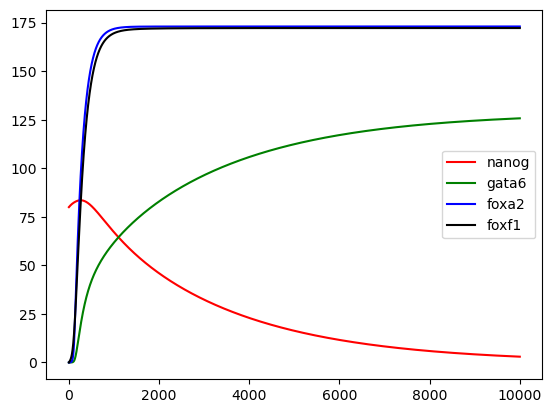

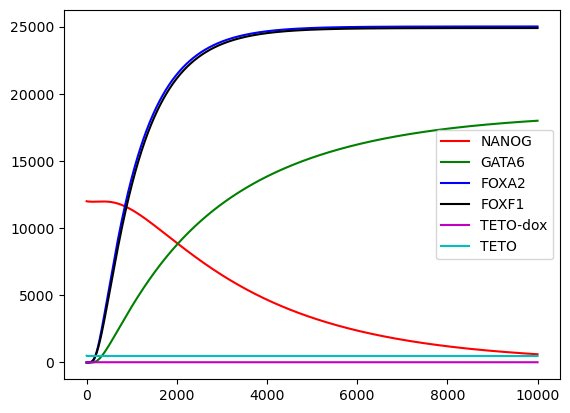

(<__main__.DeterministicCNV at 0x126bdae5810>,
 array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.998e+03, 9.999e+03,
        1.000e+04]),
 array([[1.80000000e+01, 8.00000000e+01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [7.37610817e-02, 8.00286137e+01, 1.92445115e-07, ...,
         7.34348285e-10, 1.30568075e-13, 3.54254107e-05],
        [7.37606002e-02, 8.00571021e+01, 3.84579388e-07, ...,
         1.19611776e-08, 1.12401148e-11, 1.65547678e-04],
        ...,
        [6.61484103e-02, 2.98631432e+00, 1.25734532e+02, ...,
         7.22511081e-04, 1.99855190e+00, 1.98917778e+00],
        [6.61484103e-02, 2.98530039e+00, 1.25735546e+02, ...,
         7.22511068e-04, 1.99855190e+00, 1.98917778e+00],
        [6.61484103e-02, 2.98428680e+00, 1.25736559e+02, ...,
         7.22511055e-04, 1.99855190e+00, 1.98917778e+00]]))

In [66]:
RunDeterministicCNV(dox=25, T=10000, plots=True)